# Scraping using BeautifulSoup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup

First, we look for the total number of pages 

In [2]:
url = 'http://zpp.rospotrebnadzor.ru/Forum/Appeals/AjaxindexList?page=1&searchtext=&categories=%5B%5D'
html = urlopen(url)
soup = BeautifulSoup(html, 'html')
pages = [i.text for i in soup.find_all(class_='page-number')]
lastpage = pages[-1]
print(lastpage)

2044


Then we parse the info we can get from the pages without looking into the pages with specific appeals: <br>
- links to the pages of specific appeals <br>
- author's name (*is used to compare the info with info from the specific appeal page*) <br>
- publishing date (*is used to compare the info with info from the specific appeal page*)<br>
- region <br>
- category <br>
- title of the appeal (*is used to compare the info with info from the specific appeal page*)

In [3]:
links=[]
author=[]
publishdate=[]
region=[]
category=[]
title=[]

In [4]:
#to not create unnecessary pressure on the zpp server and to avoid timeout error make a 3 second pause using time.sleep(3) 
for cp in np.arange(1,int(lastpage)+1):
    url = "http://zpp.rospotrebnadzor.ru/Forum/Appeals/AjaxindexList?page=" + str(cp) + "&searchtext=&categories=%5B%5D"
    html = urlopen(url)
    soup = BeautifulSoup(html, 'html')
    links.append([i.get('href') for i in soup.find_all(class_='appeal-title-link')])
    title.append([i.text for i in soup.find_all(class_='custom-underline')])
    author.append([i.text for i in soup.find_all(class_='appeal-element-bottom') if 'автор' in i.text.lower()])
    publishdate.append([i.text for i in soup.find_all(class_='appeal-element-bottom') if 'опубликовано' in i.text.lower()])
    region.append([i.text for i in soup.find_all(class_='appeal-element-bottom') if 'регион' in i.text.lower()])
    category.append([i.text for i in soup.find_all(class_='appeal-cat-title')])
    if cp%100==0:
        print(cp)
    time.sleep(3)
print ("Done!")

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
Done!


In [5]:
#Flattening list of lists
LinksFlat = [y for x in links for y in x]
RegionFlat = [y for x in region for y in x]
AuthorFlat = [y for x in author for y in x]
PublishDateFlat = [y for x in publishdate for y in x]
TitleFlat = [y for x in title for y in x]
CategoryFlat = [y for x in category for y in x]

In [6]:
PublishDateFormatted = [datetime.strptime(re.sub(' Опубликовано:  ', '', a), "%d.%m.%Y") for a in PublishDateFlat]

In [7]:
#Getting the rest of info from specific appeal urls found in list of links
AuthorAppeal = []
TextAppeal = []
TimeAppeal = []
TextAnswer = []
TimeAnswer = []
AppealID = []

In [8]:
for lnk in np.arange(0, (len(LinksFlat))):
    urlarticle = 'http://zpp.rospotrebnadzor.ru' + LinksFlat[lnk]
    htmlarticle = urlopen(urlarticle)
    souparticle = BeautifulSoup(htmlarticle, 'html')
    AuthorAppeal.append([i.text for i in souparticle.find_all(class_='appeal-details-auth-name')])
    TextAppeal.append([i.text for i in souparticle.find_all(class_='appeal-details-message')])
    TimeAppeal.append([i.text for i in souparticle.find_all(class_='appeal-element-bottom')])
    TextAnswer.append([i.text for i in souparticle.find_all(class_='appeal-comments-message')])
    TimeAnswer.append([i.text for i in souparticle.find_all(class_='appeal-comments-date')])
    AppealID.append(int(re.sub('http://zpp.rospotrebnadzor.ru/Forum/Appeals/Details/', '', urlarticle)))
    if lnk%100==0:
        print(lnk)
    time.sleep(3)
print ("Done!")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
Done!


In [9]:
#there are appeals with no responses - we have empty list in their stead in TextAnswer and TimeAnswer
EmptyTextAnswer = []
EmptyTimeAnswer = []

for i in range(0, len(TextAnswer)-1):
    if len(TextAnswer[i]) == 0:
        EmptyTextAnswer.append(i)
        
for i in range(0, len(TimeAnswer)-1):
    if len(TimeAnswer[i]) == 0:
        EmptyTimeAnswer.append(i)

EmptyTextAnswer == EmptyTimeAnswer

True

In [10]:
#change empty list into 'No response'
for i in EmptyTextAnswer:
    TextAnswer[i] = ['No response']
    TimeAnswer[i] = ['No response']

In [11]:
#Flattening of lists
AuthorAppealFlat = [i[0] for i in AuthorAppeal]
TextAppealFlat = [i[0] for i in TextAppeal]
TimeAppealFlat = [i[0] for i in TimeAppeal]
TextAnswerFlat = [i[0] for i in TextAnswer]
TimeAnswerFlat = [i[0] for i in TimeAnswer]

In [12]:
#Turning strings into dates
for i in range(0, len(TimeAppealFlat)):
    TimeAppealFlat[i] = re.sub(' Опубликовано:  ', '', TimeAppealFlat[i])
    
TimeAppealFormatted = [datetime.strptime(re.sub(' в ', ' ', a), "%d.%m.%Y %H:%M") for a in TimeAppealFlat]
TimeAnswerFormatted = [datetime.strptime(re.sub(' в ', ' ', a), "%d.%m.%Y %H:%M") if a!='No response' else a for a in TimeAnswerFlat]

In [16]:
HeadersList = [
    LinksFlat,
    RegionFlat,
    AuthorFlat,
    PublishDateFormatted,
    TitleFlat,
    CategoryFlat,
    AuthorAppealFlat,
    TextAppealFlat,
    TimeAppealFormatted,
    TextAnswerFlat,
    TimeAnswerFormatted,
    AppealID
]

for n in HeadersList:
    print(len(n))

10219
10219
10219
10219
10219
10219
10219
10219
10219
10219
10219
10219


In [29]:
firstdata = {
    'links': LinksFlat,
    'region': RegionFlat,
    'category': CategoryFlat,
    'author': AuthorFlat,
    'title': TitleFlat,
    'publishdateformatted': PublishDateFormatted,
}

seconddata = {
    'id':AppealID,
    'author':AuthorAppealFlat,
    'publishtime':TimeAppealFormatted,
    'appeal':TextAppealFlat,
    'answerpublishtime':TimeAnswerFormatted,
    'answer':TextAnswerFlat
}

firstdf = pd.DataFrame(data = firstdata)
seconddf = pd.DataFrame(data = seconddata)

In [30]:
firstdf.head()

,links,region,category,author,title,publishdateformatted
0,/Forum/Appeals/Details/12927,Регион: Кемеровская область,Розничная торговля,Автор: Света,\r\n Торговый киоск \r\n ...,2019-11-02
1,/Forum/Appeals/Details/12912,Регион: Ростовская область,Розничная торговля,Автор: Голец Евгений Сергеевич,\r\n установление санитарно...,2019-11-01
2,/Forum/Appeals/Details/12902,Регион: Кировская область,Розничная торговля,Автор: Валерий,\r\n Какая информация должн...,2019-10-31
3,/Forum/Appeals/Details/12900,Регион: Кемеровская область,Розничная торговля,Автор: Анна,\r\n Торговый киоск \r\n ...,2019-10-31
4,/Forum/Appeals/Details/12899,Регион: Белгородская область,Розничная торговля,Автор: Елена,\r\n Претензия по неполной ...,2019-10-31


In [19]:
seconddf.head()

,id,author,publishtime,appeal,answerpublishtime,answer
0,12927,Света,2019-11-02 17:46:00,Здравствуйте. Киоск по Авиаторов 55 Новоильинс...,2019-11-04 08:36:00,Уважаемая Светлана! \r\n\r\nОбращаем Ваше вним...
1,12912,Голец Евгений Сергеевич,2019-11-01 03:28:00,"Прошу, Вас подтвердить, что в соответствии с п...",2019-11-01 13:57:00,Уважаемый Евгений Сергеевич! На Ваше обращение...
2,12902,Валерий,2019-10-31 09:41:00,Добрый день.\r\n\r\n1. Подскажите какую информ...,2019-10-31 16:13:00,Уважаемый Валерий!\r\n\r\nМаркировка меховых и...
3,12900,Анна,2019-10-31 06:09:00,Здравствуйте. Я живу в Новоильнском районе и н...,2019-11-04 08:36:00,Уважаемая Анна! \r\n\r\nОбращаем Ваше внимание...
4,12899,Елена,2019-10-31 01:48:00,Добрый день! 07.09.2019 мною был приобретен ку...,No response,No response


In [32]:
firstdf['links'] = firstdf['links'].apply(lambda x: re.sub('/Forum/Appeals/Details/', '', x))

In [33]:
firstdf.head()

,links,region,category,author,title,publishdateformatted
0,12927,Регион: Кемеровская область,Розничная торговля,Автор: Света,\r\n Торговый киоск \r\n ...,2019-11-02
1,12912,Регион: Ростовская область,Розничная торговля,Автор: Голец Евгений Сергеевич,\r\n установление санитарно...,2019-11-01
2,12902,Регион: Кировская область,Розничная торговля,Автор: Валерий,\r\n Какая информация должн...,2019-10-31
3,12900,Регион: Кемеровская область,Розничная торговля,Автор: Анна,\r\n Торговый киоск \r\n ...,2019-10-31
4,12899,Регион: Белгородская область,Розничная торговля,Автор: Елена,\r\n Претензия по неполной ...,2019-10-31


In [34]:
firstdf['author'] = firstdf['author'].apply(lambda x: re.sub('Автор: ', '', x))

In [35]:
firstdf['region'] = firstdf['region'].apply(lambda x: re.sub('Регион: ', '', x))

In [36]:
firstdf['title'] = firstdf['title'].apply(lambda x: re.sub('\\r', '', x))
firstdf['title'] = firstdf['title'].apply(lambda x: re.sub('\\n', '', x))

In [37]:
firstdf.head()

,links,region,category,author,title,publishdateformatted
0,12927,Кемеровская область,Розничная торговля,Света,Торговый киоск ...,2019-11-02
1,12912,Ростовская область,Розничная торговля,Голец Евгений Сергеевич,установление санитарно-защ...,2019-11-01
2,12902,Кировская область,Розничная торговля,Валерий,Какая информация должна бы...,2019-10-31
3,12900,Кемеровская область,Розничная торговля,Анна,Торговый киоск ...,2019-10-31
4,12899,Белгородская область,Розничная торговля,Елена,Претензия по неполной комп...,2019-10-31


In [38]:
firstdf.rename(columns={'links': 'appeal_id'}, inplace=True)

In [42]:
firstdf['appeal_id'] = firstdf['appeal_id'].astype(int)

In [43]:
firstdf.head()

,appeal_id,region,category,author,title,publishdateformatted
0,12927,Кемеровская область,Розничная торговля,Света,Торговый киоск ...,2019-11-02
1,12912,Ростовская область,Розничная торговля,Голец Евгений Сергеевич,установление санитарно-защ...,2019-11-01
2,12902,Кировская область,Розничная торговля,Валерий,Какая информация должна бы...,2019-10-31
3,12900,Кемеровская область,Розничная торговля,Анна,Торговый киоск ...,2019-10-31
4,12899,Белгородская область,Розничная торговля,Елена,Претензия по неполной комп...,2019-10-31


In [40]:
seconddf.rename(columns={'id': 'appeal_id', 'publishtime': 'appeal_date', 'appeal': 'appeal_text', 'answerpublishtime': 'response_date', 'answer': 'response_text'}, inplace=True)

In [143]:
fulldf = pd.merge(firstdf, seconddf, on='appeal_id')

In [144]:
fulldf.head()

,appeal_id,region,category,author_x,title,publishdateformatted,author_y,appeal_date,appeal_text,response_date,response_text
0,12927,Кемеровская область,Розничная торговля,Света,Торговый киоск ...,2019-11-02,Света,2019-11-02 17:46:00,Здравствуйте. Киоск по Авиаторов 55 Новоильинс...,2019-11-04 08:36:00,Уважаемая Светлана! \r\n\r\nОбращаем Ваше вним...
1,12912,Ростовская область,Розничная торговля,Голец Евгений Сергеевич,установление санитарно-защ...,2019-11-01,Голец Евгений Сергеевич,2019-11-01 03:28:00,"Прошу, Вас подтвердить, что в соответствии с п...",2019-11-01 13:57:00,Уважаемый Евгений Сергеевич! На Ваше обращение...
2,12902,Кировская область,Розничная торговля,Валерий,Какая информация должна бы...,2019-10-31,Валерий,2019-10-31 09:41:00,Добрый день.\r\n\r\n1. Подскажите какую информ...,2019-10-31 16:13:00,Уважаемый Валерий!\r\n\r\nМаркировка меховых и...
3,12900,Кемеровская область,Розничная торговля,Анна,Торговый киоск ...,2019-10-31,Анна,2019-10-31 06:09:00,Здравствуйте. Я живу в Новоильнском районе и н...,2019-11-04 08:36:00,Уважаемая Анна! \r\n\r\nОбращаем Ваше внимание...
4,12899,Белгородская область,Розничная торговля,Елена,Претензия по неполной комп...,2019-10-31,Елена,2019-10-31 01:48:00,Добрый день! 07.09.2019 мною был приобретен ку...,No response,No response


In [145]:
fulldf.drop(columns=['author_x', 'title', 'publishdateformatted', 'author_y'], inplace=True)

In [146]:
#A bit of cleaning
fulldf['appeal_text'] = fulldf['appeal_text'].apply(lambda x: re.sub('\\r', '', x))
fulldf['appeal_text'] = fulldf['appeal_text'].apply(lambda x: re.sub('\\n', '', x))
fulldf['response_text'] = fulldf['response_text'].apply(lambda x: re.sub('\\r', '', x))
fulldf['response_text'] = fulldf['response_text'].apply(lambda x: re.sub('\\n', '', x))

In [147]:
fulldf.head()

,appeal_id,region,category,appeal_date,appeal_text,response_date,response_text
0,12927,Кемеровская область,Розничная торговля,2019-11-02 17:46:00,Здравствуйте. Киоск по Авиаторов 55 Новоильинс...,2019-11-04 08:36:00,"Уважаемая Светлана! Обращаем Ваше внимание, чт..."
1,12912,Ростовская область,Розничная торговля,2019-11-01 03:28:00,"Прошу, Вас подтвердить, что в соответствии с п...",2019-11-01 13:57:00,Уважаемый Евгений Сергеевич! На Ваше обращение...
2,12902,Кировская область,Розничная торговля,2019-10-31 09:41:00,Добрый день.1. Подскажите какую информацию дол...,2019-10-31 16:13:00,Уважаемый Валерий!Маркировка меховых изделий д...
3,12900,Кемеровская область,Розничная торговля,2019-10-31 06:09:00,Здравствуйте. Я живу в Новоильнском районе и н...,2019-11-04 08:36:00,"Уважаемая Анна! Обращаем Ваше внимание, что мо..."
4,12899,Белгородская область,Розничная торговля,2019-10-31 01:48:00,Добрый день! 07.09.2019 мною был приобретен ку...,No response,No response


In [75]:
#saving as csv file
fulldf.to_csv("zpp20191105.csv", header=True, index=False, encoding='utf-8')

In [127]:
cat_reg_data = pd.crosstab(fulldf.region, fulldf.category,margins=False).apply(lambda r: round(r/r.sum(),2), axis=1)

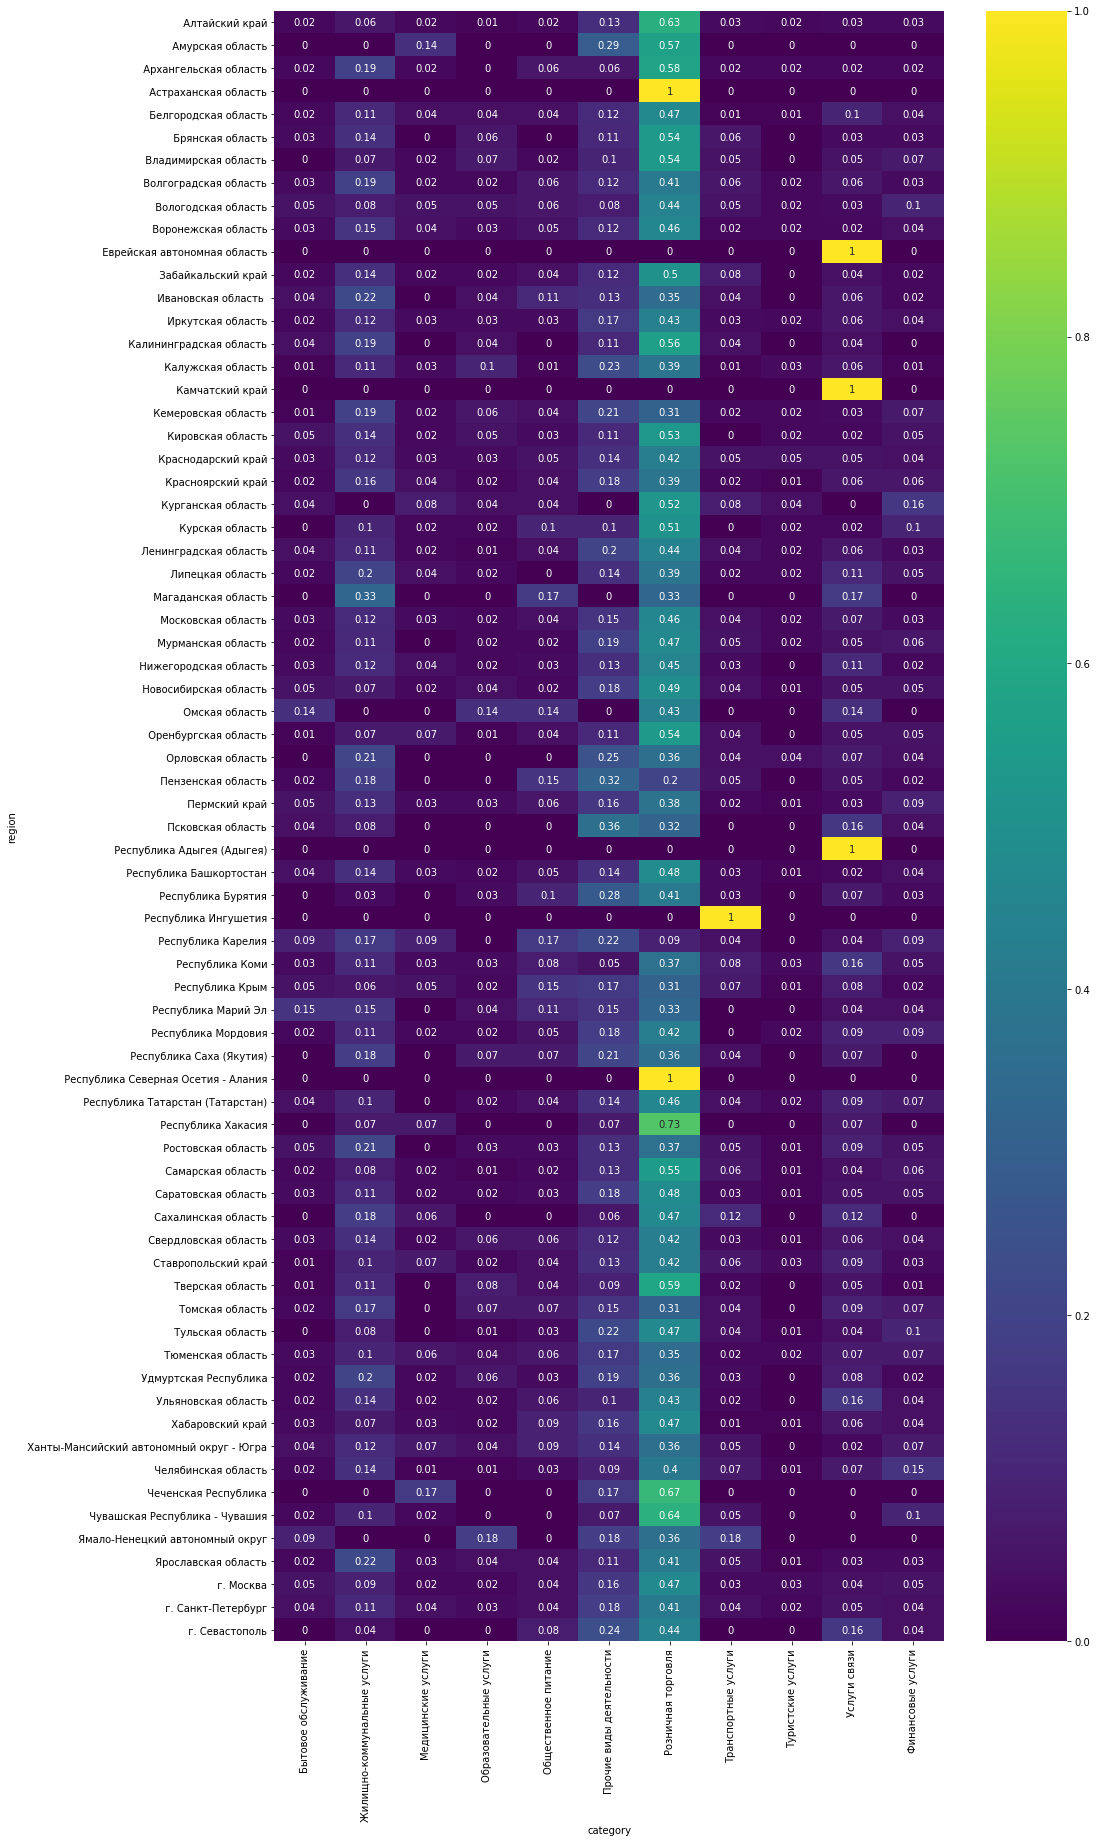

In [128]:
plt.figure(figsize=(15, 30))
sns.heatmap(cat_reg_data,
            cmap="viridis", annot=True, cbar=True, xticklabels = True, yticklabels = True)

In [61]:
CategoryFrequency = np.array(fulldf.category)
unique, counts = np.unique(CategoryFrequency, return_counts=True)

print(np.asarray((unique, counts)).T)
category_data = np.asarray((unique, counts)).T

[['Бытовое обслуживание' 352]
 ['Жилищно-коммунальные услуги' 1216]
 ['Медицинские услуги' 259]
 ['Образовательные услуги' 272]
 ['Общественное питание' 426]
 ['Прочие виды деятельности' 1537]
 ['Розничная торговля' 4557]
 ['Транспортные услуги' 383]
 ['Туристские услуги' 176]
 ['Услуги связи' 591]
 ['Финансовые услуги' 450]]


In [63]:
category_data = pd.DataFrame({'cat': category_data[:, 0], 'num': category_data[:, 1]})
print(category_data)

                            cat   num
0          Бытовое обслуживание   352
1   Жилищно-коммунальные услуги  1216
2            Медицинские услуги   259
3        Образовательные услуги   272
4          Общественное питание   426
5      Прочие виды деятельности  1537
6            Розничная торговля  4557
7           Транспортные услуги   383
8             Туристские услуги   176
9                  Услуги связи   591
10            Финансовые услуги   450


In [101]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(
    header=dict(values=list(category_data.columns),
                fill_color='darkviolet',
                align='left'),
    cells=dict(values=[category_data.cat, category_data.num, category_data.perc],
               fill_color='lavender',
               align='left'))
])

fig.show()

In [64]:
TotalSum = category_data['num'].sum()
category_data['perc'] = category_data.apply(lambda row: (round((row.num/TotalSum), 2) * 100), axis = 1) 

In [67]:
category_data.sort_values('perc', axis=0, 
                 ascending=False, inplace=True) 
print(category_data)

                            cat   num  perc
6            Розничная торговля  4557  45.0
5      Прочие виды деятельности  1537  15.0
1   Жилищно-коммунальные услуги  1216  12.0
9                  Услуги связи   591   6.0
4          Общественное питание   426   4.0
7           Транспортные услуги   383   4.0
10            Финансовые услуги   450   4.0
0          Бытовое обслуживание   352   3.0
2            Медицинские услуги   259   3.0
3        Образовательные услуги   272   3.0
8             Туристские услуги   176   2.0


In [74]:
import plotly.express as px
data = px.data.gapminder()

fig = px.bar(category_data, x='perc', y='cat', orientation='h',
             hover_data=['perc'], 
             labels={'cat':'Category of appeal', 'perc': 'Percentage of all appeals'}, height=400)
fig.show()

In [80]:
RegionFrequency = np.array(fulldf.region)
unique, counts = np.unique(RegionFrequency, return_counts=True)
region_data = np.asarray((unique, counts)).T

region_data = pd.DataFrame({'region': region_data[:, 0], 'num': region_data[:, 1]})

TotalSum = region_data['num'].sum()
region_data['perc'] = region_data.apply(lambda row: (round((row.num/TotalSum), 2) * 100), axis = 1)

region_data.sort_values('num', axis=0, 
                 ascending=False, inplace=True) 
print(region_data)

                                   region   num  perc
26                     Московская область  1845  18.0
68                              г. Москва  1620  16.0
69                     г. Санкт-Петербург   874   9.0
19                     Краснодарский край   432   4.0
49                     Ростовская область   350   3.0
37                Республика Башкортостан   312   3.0
53                   Свердловская область   278   3.0
28                  Нижегородская область   267   3.0
23                  Ленинградская область   216   2.0
47       Республика Татарстан (Татарстан)   196   2.0
29                  Новосибирская область   193   2.0
63                    Челябинская область   190   2.0
0                          Алтайский край   172   2.0
9                     Воронежская область   170   2.0
50                      Самарская область   162   2.0
20                      Красноярский край   161   2.0
34                          Пермский край   158   2.0
61                       Хаб

In [87]:
top_regions = region_data[:10]

In [102]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(top_regions.columns),
                fill_color='darkviolet',
                align='left'),
    cells=dict(values=[top_regions.region, top_regions.num, top_regions.perc],
               fill_color='lavender',
               align='left'))
])

fig.show()

In [89]:
data = px.data.gapminder()

fig = px.bar(top_regions, x='perc', y='region', orientation='h',
             hover_data=['perc'], 
             labels={'region':'', 'perc': 'Percentage of all appeals'}, height=800)
fig.show()

In [148]:
fulldf['appeal_year'], fulldf['appeal_month'] = fulldf['appeal_date'].dt.year, fulldf['appeal_date'].dt.month
fulldf.head()

,appeal_id,region,category,appeal_date,appeal_text,response_date,response_text,appeal_year,appeal_month
0,12927,Кемеровская область,Розничная торговля,2019-11-02 17:46:00,Здравствуйте. Киоск по Авиаторов 55 Новоильинс...,2019-11-04 08:36:00,"Уважаемая Светлана! Обращаем Ваше внимание, чт...",2019,11
1,12912,Ростовская область,Розничная торговля,2019-11-01 03:28:00,"Прошу, Вас подтвердить, что в соответствии с п...",2019-11-01 13:57:00,Уважаемый Евгений Сергеевич! На Ваше обращение...,2019,11
2,12902,Кировская область,Розничная торговля,2019-10-31 09:41:00,Добрый день.1. Подскажите какую информацию дол...,2019-10-31 16:13:00,Уважаемый Валерий!Маркировка меховых изделий д...,2019,10
3,12900,Кемеровская область,Розничная торговля,2019-10-31 06:09:00,Здравствуйте. Я живу в Новоильнском районе и н...,2019-11-04 08:36:00,"Уважаемая Анна! Обращаем Ваше внимание, что мо...",2019,10
4,12899,Белгородская область,Розничная торговля,2019-10-31 01:48:00,Добрый день! 07.09.2019 мною был приобретен ку...,No response,No response,2019,10


In [91]:
YearFrequency = np.array(fulldf.appeal_year)
unique, counts = np.unique(YearFrequency, return_counts=True)
year_data = np.asarray((unique, counts)).T

year_data = pd.DataFrame({'year': year_data[:, 0], 'num': year_data[:, 1]})

TotalSum = year_data['num'].sum()
year_data['perc'] = year_data.apply(lambda row: (round((row.num/TotalSum), 2) * 100), axis = 1)

year_data.sort_values('num', axis=0, 
                 ascending=False, inplace=True) 
print(year_data)

   year   num  perc
2  2018  3694  36.0
1  2017  3113  30.0
3  2019  2333  23.0
0  2016  1079  11.0


In [92]:
data = px.data.gapminder()

fig = px.bar(year_data, x='perc', y='year', orientation='h',
             hover_data=['perc'], 
             labels={'year':'', 'perc': 'Percentage of all appeals'}, height=400)
fig.show()

In [93]:
MonthFrequency = np.array(fulldf.appeal_month)
unique, counts = np.unique(MonthFrequency, return_counts=True)
month_data = np.asarray((unique, counts)).T

month_data = pd.DataFrame({'month': month_data[:, 0], 'num': month_data[:, 1]})

TotalSum = month_data['num'].sum()
month_data['perc'] = month_data.apply(lambda row: (round((row.num/TotalSum), 2) * 100), axis = 1)

month_data.sort_values('num', axis=0, 
                 ascending=False, inplace=True) 
print(month_data)

    month  num  perc
2       3  917   9.0
7       8  913   9.0
6       7  896   9.0
5       6  892   9.0
8       9  881   9.0
3       4  856   8.0
0       1  841   8.0
10     11  834   8.0
9      10  821   8.0
4       5  818   8.0
1       2  806   8.0
11     12  744   7.0


In [131]:
cat_year = pd.crosstab(fulldf.category, fulldf.appeal_year,margins=False).apply(lambda r: round(r/r.sum(),2), axis=1)

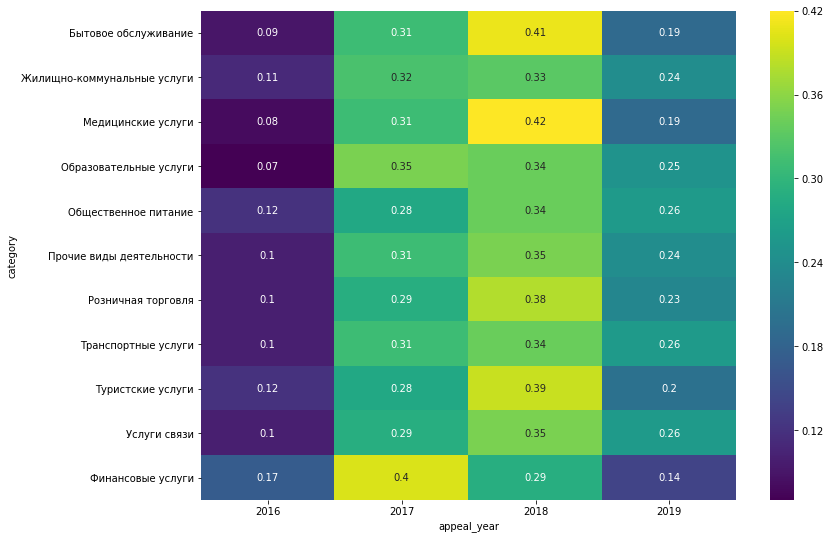

In [132]:
plt.figure(figsize=(12, 9))
sns.heatmap(cat_year,
            cmap="viridis", annot=True, cbar=True, xticklabels = True, yticklabels = True)

In [120]:
month_cat_data = pd.crosstab(fulldf.category, fulldf.appeal_month,margins=False).apply(lambda r: round(r/r.sum(),2), axis=1)
month_cat_data

appeal_month,1,2,3,4,5,6,7,8,9,10,11,12
category,,,,,,,,,,,,
Бытовое обслуживание,0.10,0.07,0.07,0.09,0.09,0.10,0.07,0.08,0.11,0.08,0.08,0.07
Жилищно-коммунальные услуги,0.09,0.08,0.09,0.09,0.06,0.09,0.09,0.09,0.08,0.10,0.08,0.06
Медицинские услуги,0.07,0.06,0.11,0.08,0.12,0.08,0.08,0.08,0.10,0.07,0.10,0.06
Образовательные услуги,0.07,0.09,0.07,0.06,0.08,0.06,0.07,0.08,0.16,0.10,0.07,0.08
Общественное питание,0.07,0.07,0.09,0.08,0.06,0.09,0.08,0.11,0.10,0.08,0.08,0.09
Прочие виды деятельности,0.07,0.08,0.09,0.09,0.09,0.09,0.09,0.09,0.07,0.09,0.07,0.07
Розничная торговля,0.08,0.08,0.09,0.08,0.08,0.09,0.09,0.09,0.09,0.07,0.08,0.08
Транспортные услуги,0.08,0.05,0.09,0.07,0.09,0.10,0.12,0.09,0.08,0.06,0.08,0.08
Туристские услуги,0.05,0.05,0.06,0.06,0.11,0.13,0.14,0.16,0.07,0.09,0.02,0.06


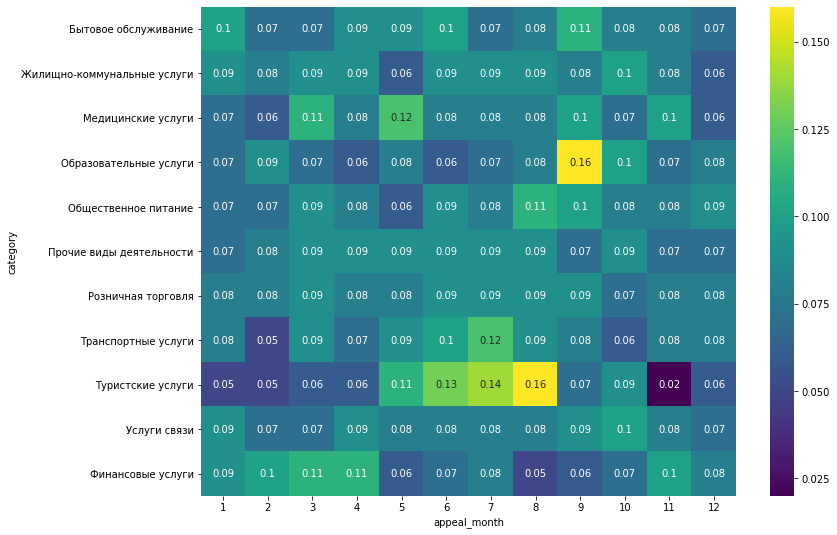

In [122]:
plt.figure(figsize=(12, 9))
sns.heatmap(month_cat_data,
            cmap="viridis", annot=True, cbar=True, xticklabels = True, yticklabels = True)

In [149]:
fulldf['response_date'].replace('No response', datetime.now(), inplace=True)
fulldf.head()

,appeal_id,region,category,appeal_date,appeal_text,response_date,response_text,appeal_year,appeal_month
0,12927,Кемеровская область,Розничная торговля,2019-11-02 17:46:00,Здравствуйте. Киоск по Авиаторов 55 Новоильинс...,2019-11-04 08:36:00.000000,"Уважаемая Светлана! Обращаем Ваше внимание, чт...",2019,11
1,12912,Ростовская область,Розничная торговля,2019-11-01 03:28:00,"Прошу, Вас подтвердить, что в соответствии с п...",2019-11-01 13:57:00.000000,Уважаемый Евгений Сергеевич! На Ваше обращение...,2019,11
2,12902,Кировская область,Розничная торговля,2019-10-31 09:41:00,Добрый день.1. Подскажите какую информацию дол...,2019-10-31 16:13:00.000000,Уважаемый Валерий!Маркировка меховых изделий д...,2019,10
3,12900,Кемеровская область,Розничная торговля,2019-10-31 06:09:00,Здравствуйте. Я живу в Новоильнском районе и н...,2019-11-04 08:36:00.000000,"Уважаемая Анна! Обращаем Ваше внимание, что мо...",2019,10
4,12899,Белгородская область,Розничная торговля,2019-10-31 01:48:00,Добрый день! 07.09.2019 мною был приобретен ку...,2019-11-06 04:51:14.861427,No response,2019,10


In [150]:
fulldf['time_before_response'] = (fulldf['response_date'] - fulldf['appeal_date']).dt.days

In [151]:
fulldf.head()

,appeal_id,region,category,appeal_date,appeal_text,response_date,response_text,appeal_year,appeal_month,time_before_response
0,12927,Кемеровская область,Розничная торговля,2019-11-02 17:46:00,Здравствуйте. Киоск по Авиаторов 55 Новоильинс...,2019-11-04 08:36:00.000000,"Уважаемая Светлана! Обращаем Ваше внимание, чт...",2019,11,1
1,12912,Ростовская область,Розничная торговля,2019-11-01 03:28:00,"Прошу, Вас подтвердить, что в соответствии с п...",2019-11-01 13:57:00.000000,Уважаемый Евгений Сергеевич! На Ваше обращение...,2019,11,0
2,12902,Кировская область,Розничная торговля,2019-10-31 09:41:00,Добрый день.1. Подскажите какую информацию дол...,2019-10-31 16:13:00.000000,Уважаемый Валерий!Маркировка меховых изделий д...,2019,10,0
3,12900,Кемеровская область,Розничная торговля,2019-10-31 06:09:00,Здравствуйте. Я живу в Новоильнском районе и н...,2019-11-04 08:36:00.000000,"Уважаемая Анна! Обращаем Ваше внимание, что мо...",2019,10,4
4,12899,Белгородская область,Розничная торговля,2019-10-31 01:48:00,Добрый день! 07.09.2019 мною был приобретен ку...,2019-11-06 04:51:14.861427,No response,2019,10,6


In [152]:
pd.crosstab(fulldf.time_before_response, fulldf.category)

category,Бытовое обслуживание,Жилищно-коммунальные услуги,Медицинские услуги,Образовательные услуги,Общественное питание,Прочие виды деятельности,Розничная торговля,Транспортные услуги,Туристские услуги,Услуги связи,Финансовые услуги
time_before_response,,,,,,,,,,,
0,42,194,41,41,59,212,704,51,23,90,65
1,31,142,31,32,40,172,528,34,15,65,50
2,32,87,24,23,37,129,405,33,14,61,32
3,18,79,16,18,20,101,306,27,15,39,29
4,20,59,10,16,26,88,242,22,11,28,25
5,16,53,9,7,23,62,172,18,5,25,19
6,10,39,13,13,14,56,156,10,6,27,15
7,4,37,4,8,13,45,140,13,4,15,8
8,4,33,2,9,11,37,74,5,4,18,5
